<a href="https://colab.research.google.com/github/jeffhoro/Portfolio/blob/main/Data_Analysis_NYPD_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYPD Crime Reports Dataset

Analysis of dataset with all the valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of 2023.

The dataset is available at:
https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i

Dataset contains ~8 million crimes reported to NYPD.

## Attribute Description

Below you can find the description of the attributes, and their datatypes.

| Column | Description | Data Type
|--------|-------------------|----|
| CMPLNT_NUM | Randomly generated persistent ID for each complaint  | bigint(20) |
| CMPLNT_FR | Exact datetime of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists) | datetime |
| CMPLNT_TO | Ending datetime of occurrence for the reported event, if exact time of occurrence is unknown | datetime
| RPT_DT | Date event was reported to police  | date
| KY_CD | Three digit offense classification code | char(3)
| PD_CD | Three digit internal classification code (more granular than Key Code) | char(3)
| JURISDICTION_CODE	| | smallint(6)
| CRM_ATPT_CPTD_CD | Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely | enum('COMPLETED','ATTEMPTED')
| LAW_CAT_CD | Level of offense: felony, misdemeanor, violation  | enum('FELONY','MISDEMEANOR','VIOLATION')
| BORO_NM | The name of the borough in which the incident occurred | enum('BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND')
| ADDR_PCT_CD | The precinct in which the incident occurred | char(3)
| LOC_OF_OCCUR_DESC | Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of | enum('FRONT OF','INSIDE','OPPOSITE OF','OUTSIDE','REAR OF')
| PATROL_BORO | |	enum('PATROL BORO BRONX','PATROL BORO BKLYN SOUTH','PATROL BORO BKLYN NORTH','PATROL BORO MAN SOUTH','PATROL BORO MAN NORTH','PATROL BORO QUEENS NORTH','PATROL BORO QUEENS SOUTH','PATROL BORO STATEN ISLAND')
| PREM_TYP_DESC | Specific description of premises; grocery store, residence, street, etc. | varchar(80)
| SUSP_RACE  | |		enum('UNKNOWN','BLACK','WHITE','WHITE HISPANIC','ASIAN / PACIFIC ISLANDER','BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE')
| VIC_RACE  | |		enum('UNKNOWN','BLACK','WHITE','WHITE HISPANIC','ASIAN / PACIFIC ISLANDER','BLACK HISPANIC','AMERICAN INDIAN/ALASKAN NATIVE')
| SUSP_AGE_GROUP  | |		enum('<18','18-24','25-44','45-64','65+')
| VIC_AGE_GROUP  | |		enum('<18','18-24','25-44','45-64','65+')
| SUSP_SEX  | |		enum('M','F')
| VIC_SEX  | |	enum('M','F','E','D')
| Latitude | Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)  | double
| Longitude | Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326) | double


### Auxiliary Tables

There are also have three auxiliary tables `jurisdiction_codes`, `offense_codes`, `penal_codes`, which provide descriptions for the `JURISDICTION_CODE`, `KY_CD`, and `PD_CD` attributes of the main table.




Additional Notes: https://www1.nyc.gov/assets/nypd/downloads/pdf/analysis_and_planning/incident_level_data_footnotes.pdf



## MySQL Database

For convenience, the dataset is stored in the `nypd` database at the MySQL IP address `35.221.14.222`. You can connect and see the dataset using your standard username and password (`student`, `dwdstudent2015`).

In [ ]:
!sudo pip3 install  -U -q  PyMySQL sqlalchemy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.5 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
import geopandas as gpd
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as py
import numpy as np
from matplotlib import dates as mdates

In [ ]:
conn_string = 'mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset={encoding}'.format(
    user='student',
    password='dwdstudent2015',
    host = '35.221.14.222',
    port=3306,
    db='nypd',
    encoding = 'utf8'
)
engine = create_engine(conn_string)

# Analysis


## Topic 1: Composition of Crimes

* How many total reported crimes are in the dataset?
* Analyze the column `LAW_CAT_CD` and provide the breakdown of the reported crimes among `FELONY`,`MISDEMEANOR`, and `VIOLATION`, i.e., report the number of felonies, misdemeanors, and violations. Create a bar plot showing the values across the three crime types.
* Across **felonies**, report the number of crimes, broken down by  offense description (as reported in the `OFNS_DESC` column of the `offense_codes` table). Create a bar plot showing the frequency of the top-10 offense descriptions for the felonies.

In [ ]:
# How many total reported crimes are in the dataset?

sql = '''
	select count(*)
	from nypd
'''
with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

count(*)
0   8841059

In [ ]:
# Analyze the column LAW_CAT_CD and report the number of felonies, misdemeanors, and violations.

sql = '''
select LAW_CAT_CD, count(*) COUNT
from nypd
group by LAW_CAT_CD
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

LAW_CAT_CD    COUNT
0       FELONY  2769365
1  MISDEMEANOR  4873141
2    VIOLATION  1198553

(array([0, 1, 2]),
 [Text(0, 0, 'FELONY'), Text(1, 0, 'MISDEMEANOR'), Text(2, 0, 'VIOLATION')])

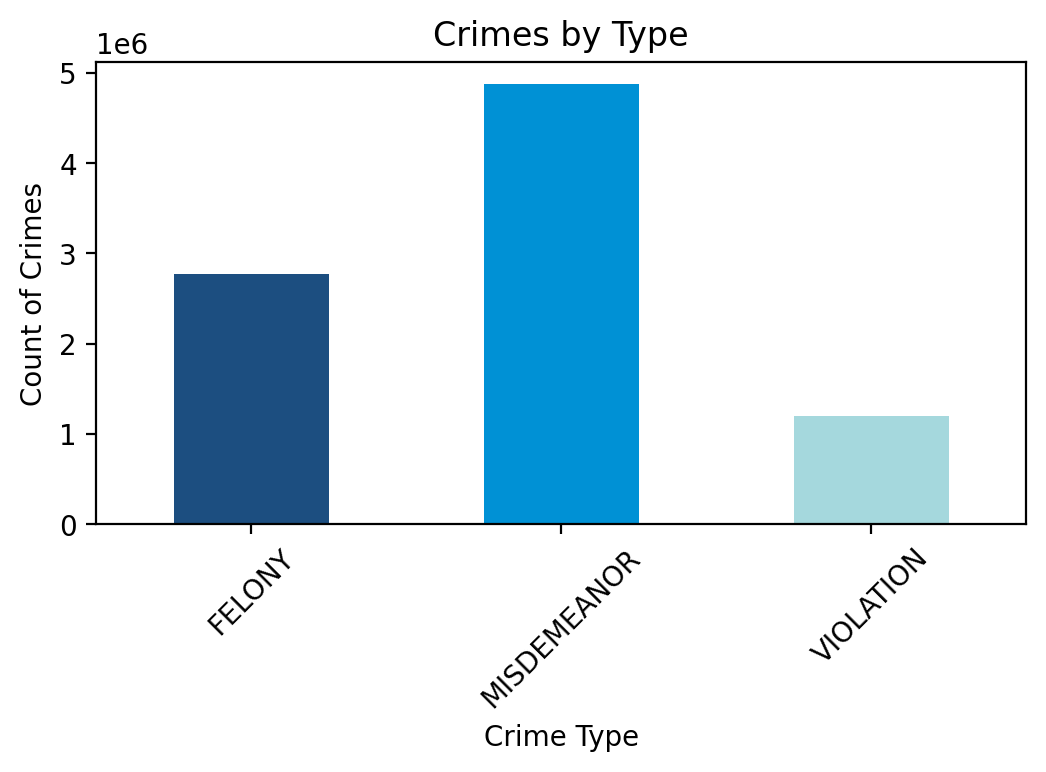

In [ ]:
# Bar plot showing the values across the three crime types.

df.plot(
    x='LAW_CAT_CD',
    y='COUNT',
    kind="bar",
    title ='Crimes by Type',
    color=['#1C4E80','#0091D5','#A5D8DD'],
    ylabel='Count of Crimes',
    xlabel='Crime Type',
    figsize = (6,3),
    legend=False
)

py.xticks(rotation=45)

In [ ]:
# Across felonies, report the number of crimes, broken down by offense description (as reported in the OFNS_DESC column)

sql = '''
select OC.OFNS_DESC, count(*) COUNT
from nypd N
inner join offense_codes OC on N.KY_CD = OC.KY_CD
where N.LAW_CAT_CD = "FELONY"
group by OC.OFNS_DESC
order by COUNT desc
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

OFNS_DESC   COUNT
0                      GRAND LARCENY  779173
1                     FELONY ASSAULT  360935
2                            ROBBERY  313118
3                           BURGLARY  295824
4            MISCELLANEOUS PENAL LAW  219169
5     GRAND LARCENY OF MOTOR VEHICLE  172571
6     CRIMINAL MISCHIEF & RELATED OF  166339
7                    DANGEROUS DRUGS   98210
8                            FORGERY   87594
9                        THEFT-FRAUD   87174
10                 DANGEROUS WEAPONS   86204
11                              RAPE   26183
12                        SEX CRIMES   22240
13                             ARSON   19412
14     POSSESSION OF STOLEN PROPERTY   16031
15      NYS LAWS-UNCLASSIFIED FELONY    9478
16   MURDER & NON-NEGL. MANSLAUGHTER    4057
17     KIDNAPPING & RELATED OFFENSES    3325
18     CHILD ABANDONMENT/NON SUPPORT     714
19  OTHER STATE LAWS (NON PENAL LAW)     451
20   PROSTITUTION & RELATED OFFENSES     331
21    HOMICIDE-NEGLIGENT,UNCLASSIFIE     234
22         CANNABIS RELATED OFFENSES     175
23                          GAMBLING     161
24        HOMICIDE-NEGLIGENT-VEHICLE     124
25      INTOXICATED/IMPAIRED DRIVING      80
26    OFFENSES AGAINST PUBLIC ADMINI      13
27      ASSAULT 3 & RELATED OFFENSES      11
28     OFF. AGNST PUB ORD SENSBLTY &      11
29                          ABORTION       7
30                     HARRASSMENT 2       6
31                 CRIMINAL TRESPASS       2
32                            FRAUDS       2
33               ADMINISTRATIVE CODE       1
34                     PETIT LARCENY       1
35    INTOXICATED & IMPAIRED DRIVING       1
36    OTHER OFFENSES RELATED TO THEF       1
37       OFFENSES AGAINST THE PERSON       1
38         NEW YORK CITY HEALTH CODE       1

(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.,
        700000., 800000., 900000.]),
 [Text(0.0, 0, '0'),
  Text(100000.0, 0, '100000'),
  Text(200000.0, 0, '200000'),
  Text(300000.0, 0, '300000'),
  Text(400000.0, 0, '400000'),
  Text(500000.0, 0, '500000'),
  Text(600000.0, 0, '600000'),
  Text(700000.0, 0, '700000'),
  Text(800000.0, 0, '800000'),
  Text(900000.0, 0, '900000')])

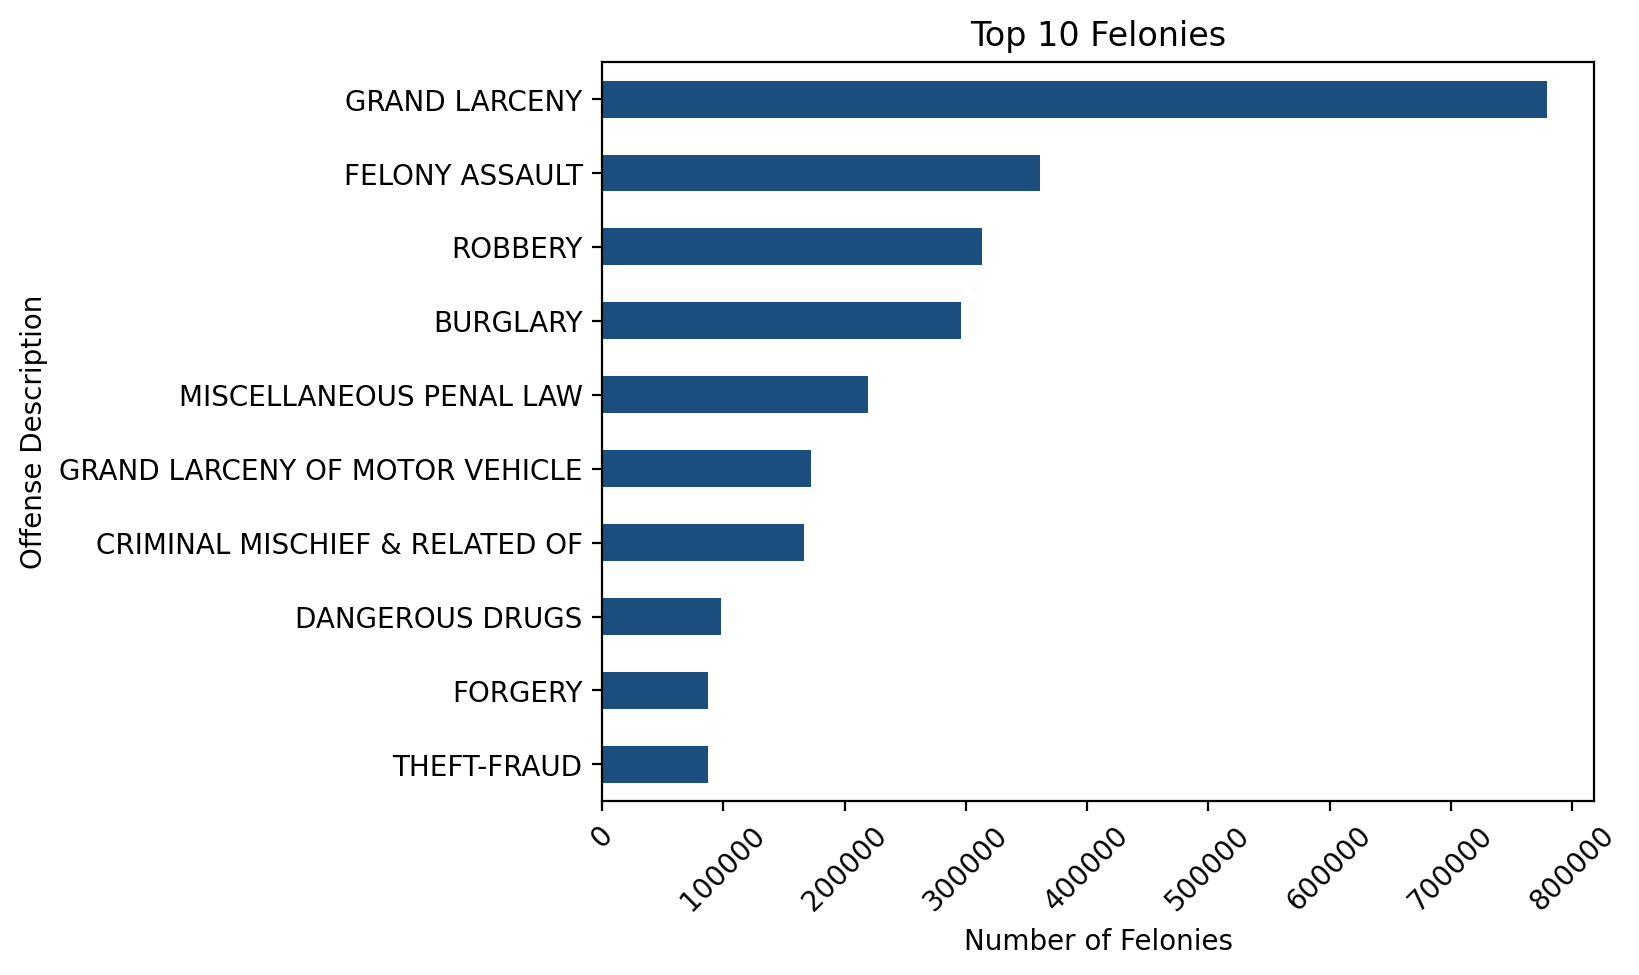

In [ ]:
# Bar plot showing the frequency of the top-10 offense descriptions
# Limit data to top 10 entries, sorted

df_top10 = df.head(10).sort_values(by=['COUNT'], ascending=True)

df_top10.plot(
    kind='barh',
    x='OFNS_DESC',
    y='COUNT',
    ylabel='Offense Description',
    xlabel='Number of Felonies',
    title = 'Top 10 Felonies',
    legend=False,
    color=['#1C4E80']
)

py.xticks(rotation=45)

## Topic 2: Is crime increasing or decreasing in NYC?

Use the column `CMPLNT_FR` that reports the date/time of the crime. Analyze the crimes that happened between January 1st 2006 and December 31st 2023.

* **Create a plot that shows the *total* number of all** reported crimes *per year*.

* **Create a plot that shows the *total* number of all** reported crimes *per month*  (ie Jan-2006, Feb-2006, ... Jan-2007, Feb-2007, ..., Dec-2023).

In [ ]:
# Plot that shows the total number of all reported crimes per year.
sql = '''
select date_format(CMPLNT_FR, '%Y') YEAR, count(*) COUNT
from nypd
where CMPLNT_FR between '2006-01-01' and '2023-12-31'
group by date_format(CMPLNT_FR, '%Y')
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

YEAR   COUNT
0   2006  519333
1   2007  528067
2   2008  525874
3   2009  509171
4   2010  506661
5   2011  497330
6   2012  503439
7   2013  494531
8   2014  490694
9   2015  477488
10  2016  477206
11  2017  467064
12  2018  461473
13  2019  457756
14  2020  412528
15  2021  447082
16  2022  526065
17  2023  518383

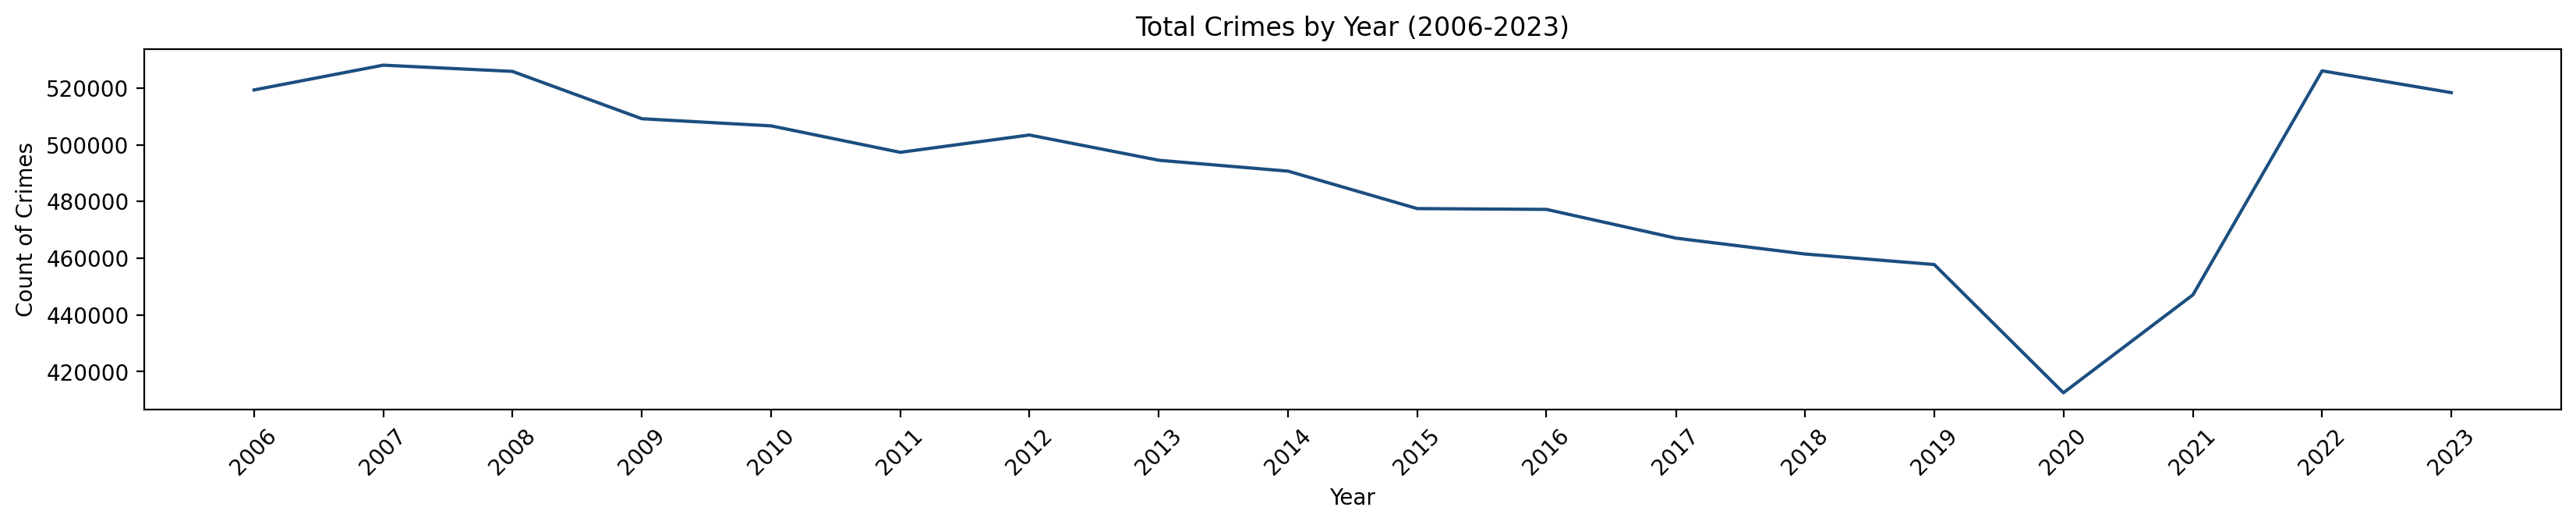

In [ ]:
# Plot that shows the total number of all reported crimes per year.

df['YEAR']=pd.to_datetime(df['YEAR'])

fig, ax = py.subplots(figsize=(20, 3))
ax.plot(df['YEAR'], df['COUNT'], color='#1C4E80')
ax.set_xlabel('Year')
ax.set_ylabel('Count of Crimes')
ax.set_title('Total Crimes by Year (2006-2023)')

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

py.xticks(rotation=45)
py.show()

In [ ]:
# Plot that shows the total number of all reported crimes per month (ie Jan-2006, Feb-2006, ... Jan-2007, Feb-2007,.. Dec-2023).

sql = '''
select date_format(CMPLNT_FR, '%Y-%m') MONTH, count(*) COUNT
from nypd
where CMPLNT_FR between '2006-01-01' and '2023-12-31'
group by date_format(CMPLNT_FR, '%Y-%m')
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

MONTH  COUNT
0    2006-01  43310
1    2006-02  36309
2    2006-03  42796
3    2006-04  41250
4    2006-05  44756
..       ...    ...
211  2023-08  45396
212  2023-09  42392
213  2023-10  45015
214  2023-11  41268
215  2023-12  38335

[216 rows x 2 columns]

In [ ]:
# Convert DATE column to datetime
df['MONTH']=pd.to_datetime(df['MONTH'])

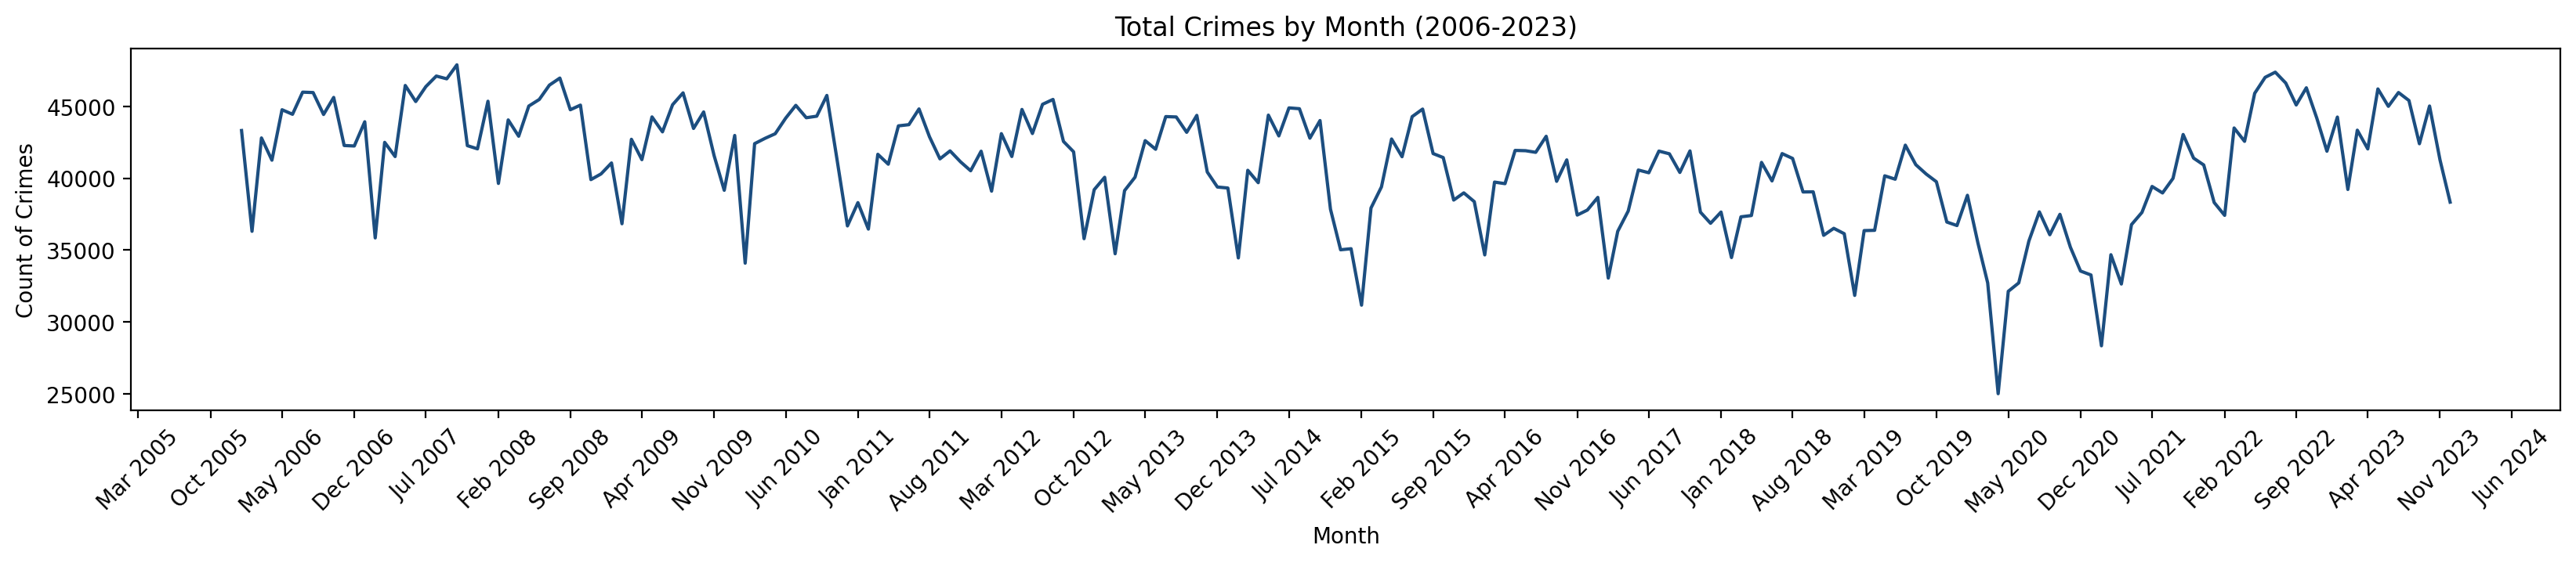

In [ ]:
# Plot that shows the total number of all reported crimes per month (ie Jan-2006, Feb-2006, ... Jan-2007, Feb-2007, ... Dec-2023).

fig, ax = py.subplots(figsize=(20, 3))
ax.plot(df['MONTH'], df['COUNT'], color='#1C4E80')
ax.set_xlabel('Month')
ax.set_ylabel('Count of Crimes')
ax.set_title('Total Crimes by Month (2006-2023)')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

py.xticks(rotation=45)
py.show()

## Topic 3: Analysis of the "Big-7" felonies

The NYPD calls the following types of felonies as the "big-7" crimes, as they tend to affect most the quality of life:

* GRAND LARCENY
* ROBBERY
* FELONY ASSAULT
* BURGLARY
* GRAND LARCENY OF MOTOR VEHICLE
* RAPE
* MURDER & NON-NEGL. MANSLAUGHTER


Focus on the big-7 felonies and report the number of these crimes over time, from 2006 till 2023, **broken down by type of felony**. Focus on reporting the **total** number of crimes per category, on a **per month** basis (Jan-06, Feb-06, ... Dec-23). Generate the associated plot with the number of big-7 felonies over time. Make the y-axis logarithmic as the different felonies have different orders of magnitude.



In [ ]:
# Gather raw data for the 7 big felonies
sql = '''
select date_format(CMPLNT_FR, '%Y-%m') DATE, OC.OFNS_DESC DESCRIPTION, count(*) COUNT
from nypd N
inner join offense_codes OC on N.KY_CD = OC.KY_CD
where OC.OFNS_DESC in('GRAND LARCENY','ROBBERY','FELONY ASSAULT','BURGLARY','GRAND LARCENY OF MOTOR VEHICLE','RAPE','MURDER & NON-NEGL. MANSLAUGHTER') and (CMPLNT_FR between '2006-01-01' and '2023-12-31')
group by date_format(CMPLNT_FR, '%Y-%m'), DESCRIPTION
order by date_format(CMPLNT_FR, '%Y-%m')
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

In [ ]:
# Convert DATE to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

In [ ]:
# Filter for individual felonies and set to new dataframes
df_rape=df[df['DESCRIPTION']=='RAPE']
df_burglary=df[df['DESCRIPTION']=='BURGLARY']
df_grandlarceny = df[df['DESCRIPTION']=='GRAND LARCENY']
df_robbery = df[df['DESCRIPTION']=='ROBBERY']
df_assault = df[df['DESCRIPTION']=='FELONY ASSAULT']
df_glmotor = df[df['DESCRIPTION']=='GRAND LARCENY OF MOTOR VEHICLE']
df_murder = df[df['DESCRIPTION']=='MURDER & NON-NEGL. MANSLAUGHTER']

In [ ]:
# Reset indexes to DATE
df_rape = df_rape.set_index(df_rape['DATE'])
df_burglary = df_burglary.set_index(df_burglary['DATE'])
df_grandlarceny = df_grandlarceny.set_index(df_grandlarceny['DATE'])
df_robbery = df_robbery.set_index(df_robbery['DATE'])
df_assault = df_assault.set_index(df_assault['DATE'])
df_glmotor = df_glmotor.set_index(df_glmotor['DATE'])
df_murder = df_murder.set_index(df_murder['DATE'])

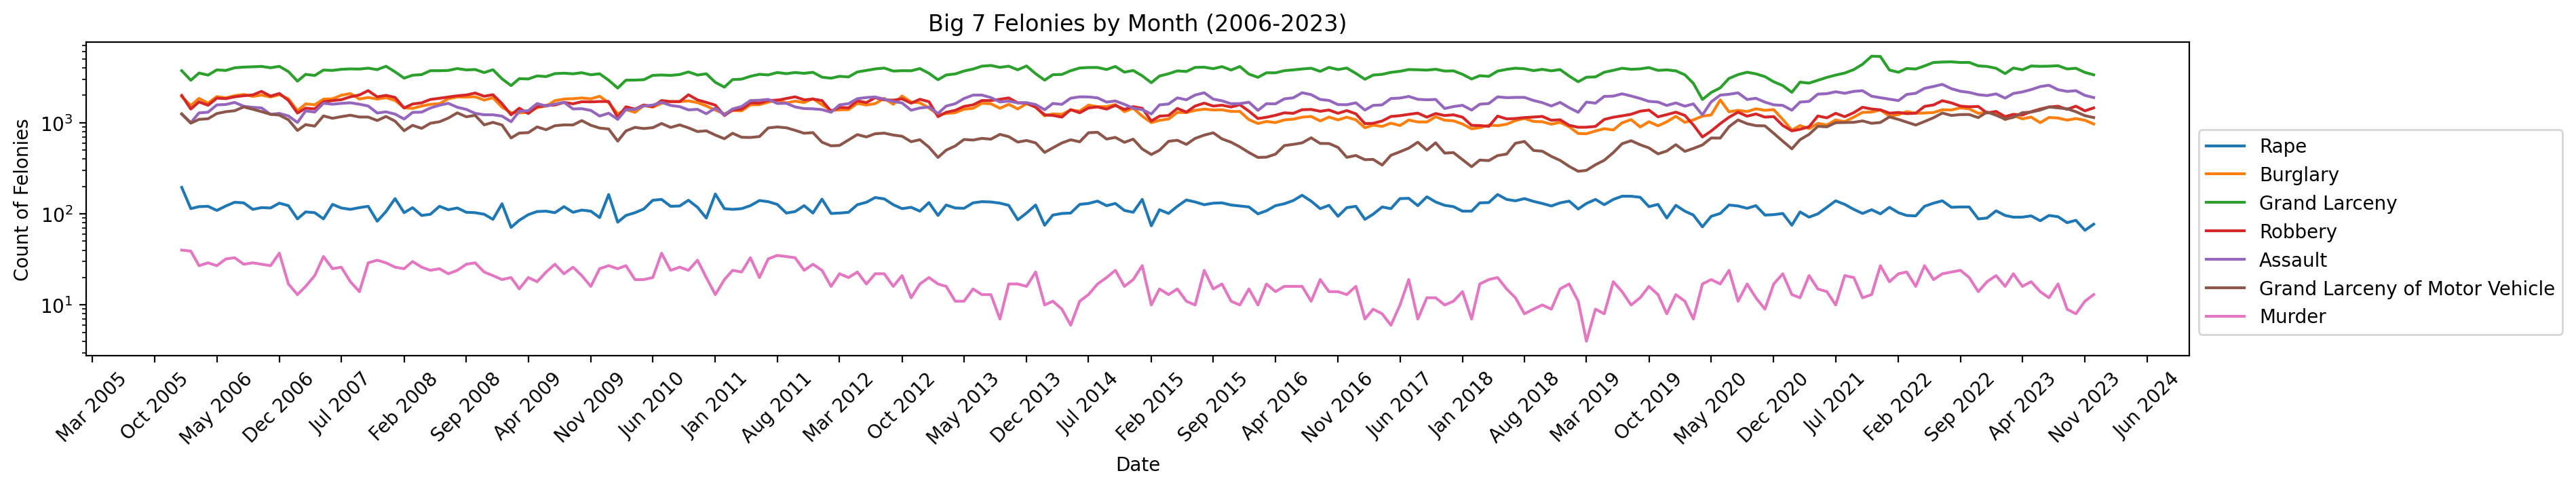

In [ ]:
# Make plots
fig, ax = py.subplots(figsize=(20, 3))
ax.plot(df_rape['DATE'], df_rape['COUNT'], label='Rape')
ax.plot(df_burglary['DATE'], df_burglary['COUNT'], label='Burglary')
ax.plot(df_grandlarceny['DATE'], df_grandlarceny['COUNT'], label='Grand Larceny')
ax.plot(df_robbery['DATE'], df_robbery['COUNT'], label ='Robbery')
ax.plot(df_assault['DATE'], df_assault['COUNT'], label ='Assault')
ax.plot(df_glmotor['DATE'], df_glmotor['COUNT'], label='Grand Larceny of Motor Vehicle')
ax.plot(df_murder['DATE'], df_murder['COUNT'], label='Murder')

ax.set_xlabel('Date')
ax.set_ylabel('Count of Felonies')
ax.set_title('Big 7 Felonies by Month (2006-2023)')

# Formatting the x-axis to show every third month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

py.yscale('log')
py.xticks(rotation=45)
py.legend(bbox_to_anchor=(1, 0.75))
py.show()

## Topic 4: Analyze the Big-7 felonies based on hour of the day.

Break down the different big-7 felonies by hour of day. We only want to calculate statistics based on the time of the day (i.e., 24 data points per crime). No need to generate the time series from 2006 to 2023 with hourly granularity.

* Show the number of big-7 felonies, broken down by hour of day. (e.g., _8375 reported robberies at 5am_). Generate a plot with the results.

* Show the number of big-7 felonies, broken down by hour of day. To allow for easier comparison among felonies, **normalize** the data by dividing by the total incidents for each type of felony.  (e.g., _2.8% of the reported robberies happen at 5am_). Generate a bar plot with the results.



In [ ]:
sql = '''
select date_format(CMPLNT_FR, '%H') HOUR, OC.OFNS_DESC DESCRIPTION, count(*) COUNT
from nypd N
inner join offense_codes OC on N.KY_CD = OC.KY_CD
where OC.OFNS_DESC in('GRAND LARCENY','ROBBERY','FELONY ASSAULT','BURGLARY','GRAND LARCENY OF MOTOR VEHICLE','RAPE','MURDER & NON-NEGL. MANSLAUGHTER') and (CMPLNT_FR between '2006-01-01' and '2023-12-31')
group by date_format(CMPLNT_FR, '%H'), DESCRIPTION
order by date_format(CMPLNT_FR, '%H')
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

HOUR                      DESCRIPTION  COUNT
0     00                         BURGLARY  10207
1     00                   FELONY ASSAULT  19813
2     00                    GRAND LARCENY  43627
3     00   GRAND LARCENY OF MOTOR VEHICLE   7669
4     00  MURDER & NON-NEGL. MANSLAUGHTER    219
..   ...                              ...    ...
163   23                    GRAND LARCENY  24600
164   23   GRAND LARCENY OF MOTOR VEHICLE  12061
165   23  MURDER & NON-NEGL. MANSLAUGHTER    230
166   23                             RAPE   1439
167   23                          ROBBERY  17411

[168 rows x 3 columns]

Text(0.5, 0, 'Hour')

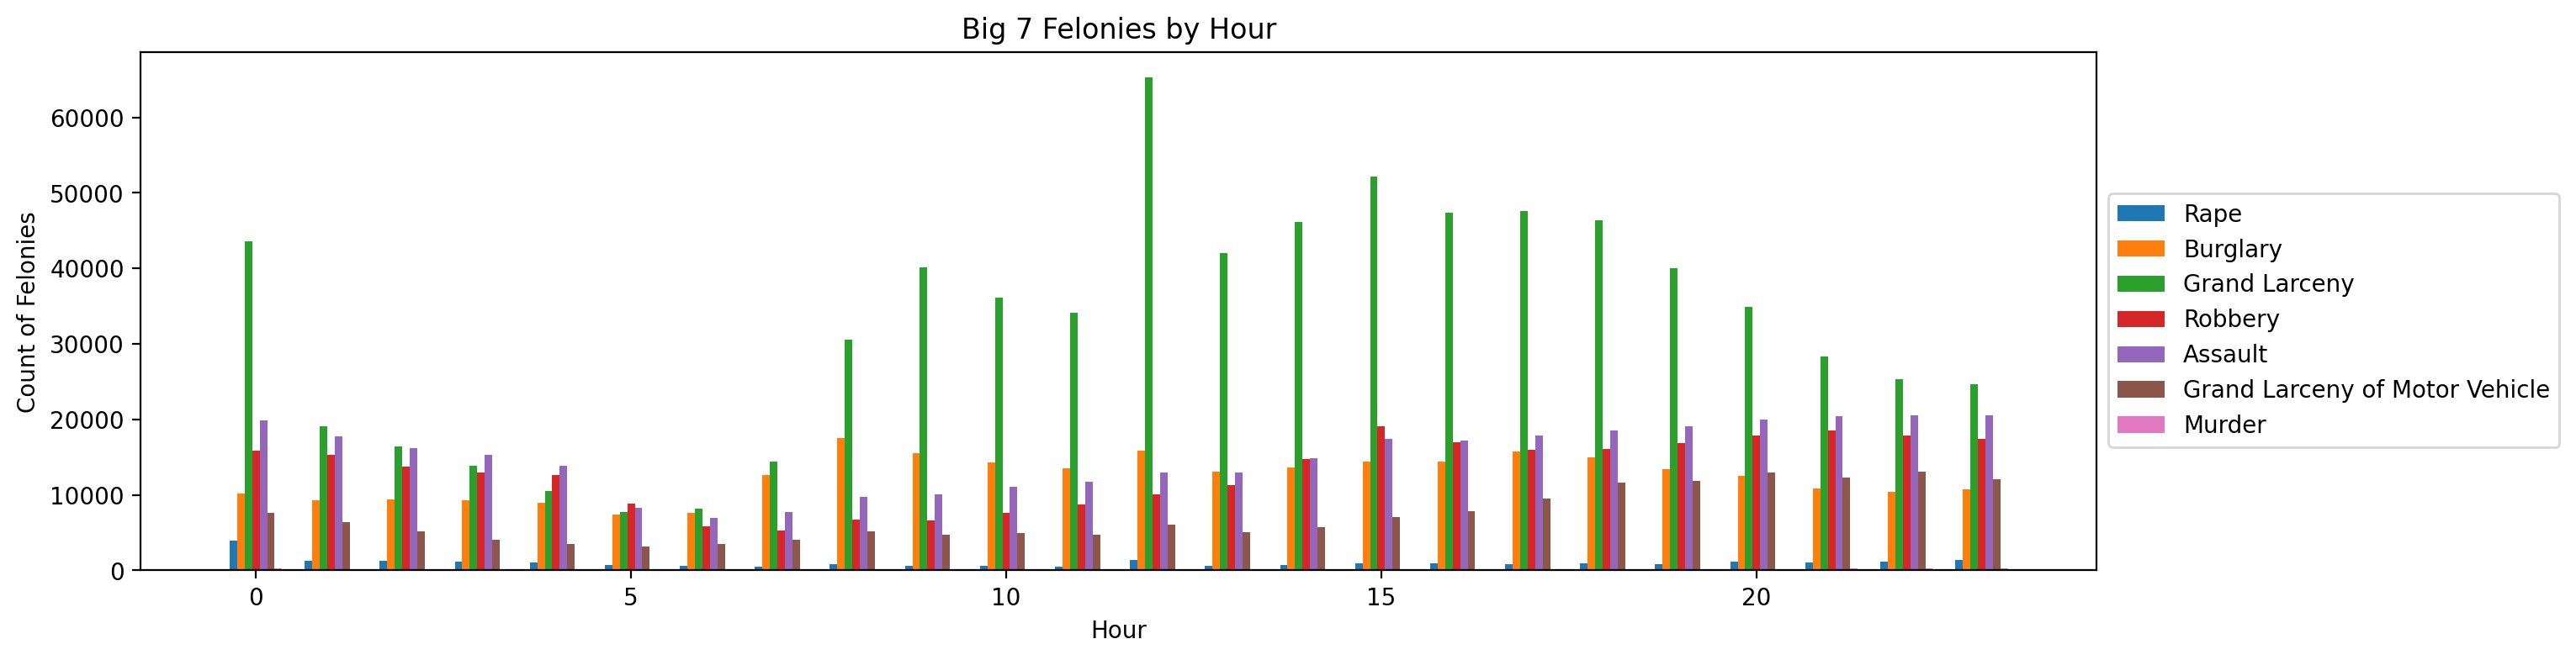

In [ ]:
# Show the number of big-7 felonies, broken down by hour of day.

df_rape=df[df['DESCRIPTION']=='RAPE']
df_burglary=df[df['DESCRIPTION']=='BURGLARY']
df_grandlarceny = df[df['DESCRIPTION']=='GRAND LARCENY']
df_robbery = df[df['DESCRIPTION']=='ROBBERY']
df_assault = df[df['DESCRIPTION']=='FELONY ASSAULT']
df_glmotor = df[df['DESCRIPTION']=='GRAND LARCENY OF MOTOR VEHICLE']
df_murder = df[df['DESCRIPTION']=='MURDER & NON-NEGL. MANSLAUGHTER']

# Set indexes to HOUR
df_rape = df_rape.set_index(df_rape['HOUR'])
df_burglary = df_burglary.set_index(df_burglary['HOUR'])
df_grandlarceny = df_grandlarceny.set_index(df_grandlarceny['HOUR'])
df_robbery = df_robbery.set_index(df_robbery['HOUR'])
df_assault = df_assault.set_index(df_assault['HOUR'])
df_glmotor = df_glmotor.set_index(df_glmotor['HOUR'])
df_murder = df_murder.set_index(df_murder['HOUR'])
# make plots
fig, ax = py.subplots(figsize=(15,4))
ind = np.arange(24)
width = 0.1

# Plotting bars for each dataset
p1 = ax.bar(ind - 3*width, df_rape['COUNT'], width, label = 'Rape')
p2 = ax.bar(ind - 2*width, df_burglary['COUNT'], width, label = 'Burglary')
p3 = ax.bar(ind - 1*width, df_grandlarceny['COUNT'], width, label = 'Grand Larceny')
p4 = ax.bar(ind, df_robbery['COUNT'], width, label = 'Robbery')
p5 = ax.bar(ind + 1*width, df_assault['COUNT'], width, label = 'Assault')
p6 = ax.bar(ind + 2*width, df_glmotor['COUNT'], width, label = 'Grand Larceny of Motor Vehicle')
p7 = ax.bar(ind + 3*width, df_murder['COUNT'], width, label = 'Murder')

ax.legend(bbox_to_anchor=(1, 0.75))
ax.set_title('Big 7 Felonies by Hour')
ax.set_ylabel('Count of Felonies')
ax.set_xlabel('Hour')

In [ ]:
# Show the number of big-7 felonies, broken down by hour of day.
# To allow for easier comparison among felonies, normalize the data by dividing
# by the total incidents for each type of felony. (e.g., 2.8% of the reported
# robberies happen at 5am). Generate a bar plot with the results.
df_rape_total = df_rape['COUNT'].sum()
df_rape['PERCENT'] = df_rape['COUNT'] / df_rape_total

df_burglary_total = df_burglary['COUNT'].sum()
df_burglary['PERCENT'] = df_burglary['COUNT'] / df_burglary_total

df_gl_total = df_grandlarceny['COUNT'].sum()
df_grandlarceny['PERCENT'] = df_grandlarceny['COUNT'] / df_gl_total

df_robbery_total = df_robbery['COUNT'].sum()
df_robbery['PERCENT'] = df_robbery['COUNT'] / df_robbery_total

df_assault_total = df_assault['COUNT'].sum()
df_assault['PERCENT'] = df_assault['COUNT'] / df_assault_total

df_glmotor_total = df_glmotor['COUNT'].sum()
df_glmotor['PERCENT'] = df_glmotor['COUNT'] / df_glmotor_total

df_murder_total = df_murder['COUNT'].sum()
df_murder['PERCENT'] = df_murder['COUNT'] / df_murder_total


Text(0.5, 0, 'Hour')

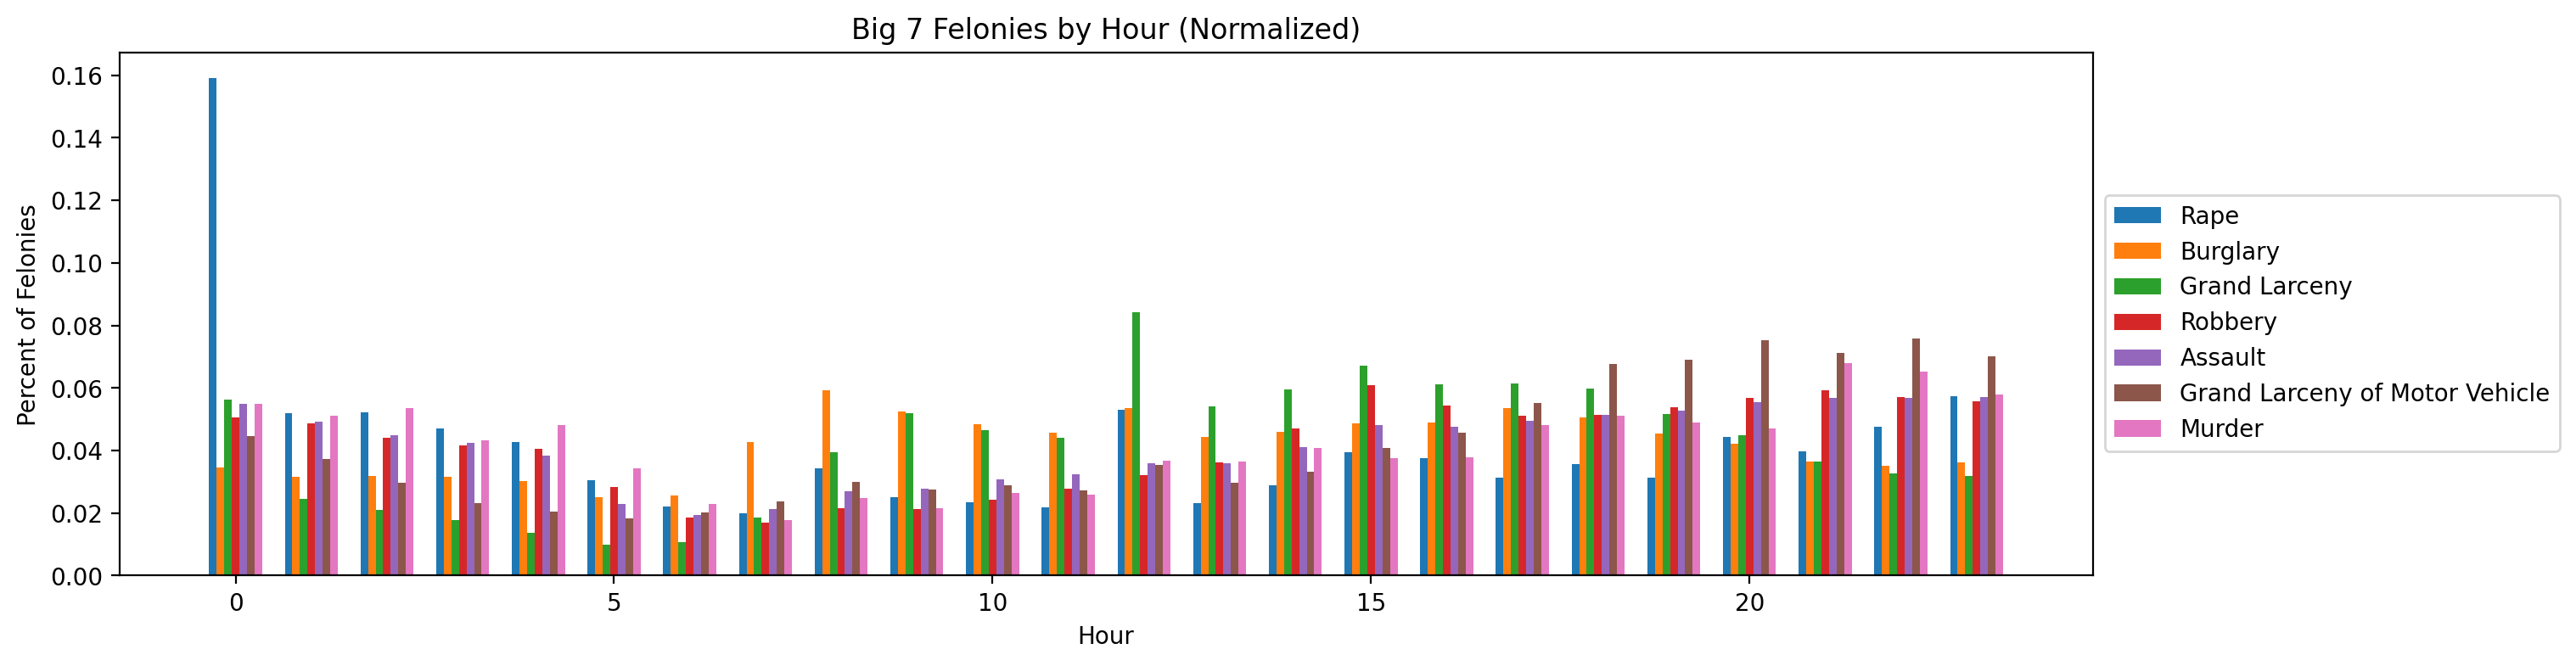

In [ ]:
fig, ax = py.subplots(figsize=(15,4))
ind = np.arange(24)
width = 0.1

# Plotting bars for each dataset
p1 = ax.bar(ind - 3*width, df_rape['PERCENT'], width, label = 'Rape')
p2 = ax.bar(ind - 2*width, df_burglary['PERCENT'], width, label = 'Burglary')
p3 = ax.bar(ind - 1*width, df_grandlarceny['PERCENT'], width, label = 'Grand Larceny')
p4 = ax.bar(ind, df_robbery['PERCENT'], width, label = 'Robbery')
p5 = ax.bar(ind + 1*width, df_assault['PERCENT'], width, label = 'Assault')
p6 = ax.bar(ind + 2*width, df_glmotor['PERCENT'], width, label = 'Grand Larceny of Motor Vehicle')
p7 = ax.bar(ind + 3*width, df_murder['PERCENT'], width, label = 'Murder')

ax.legend(bbox_to_anchor=(1, 0.75))
ax.set_title('Big 7 Felonies by Hour (Normalized)')
ax.set_ylabel('Percent of Felonies')
ax.set_xlabel('Hour')

## Topic 5: Spatial Analysis

Analyze the spatial density for the following types of felonies:

* GRAND LARCENY
* ROBBERY
* FELONY ASSAULT
* BURGLARY
* GRAND LARCENY OF MOTOR VEHICLE

Use the `Latitude` and `Longitude` variables from the dataset to identify the location of each crime. **Limit your analysis to  dates in 2023 and to crimes where  `Latitude` and `Longitude` are not NULL .**

In [ ]:
# Dataset from NYC Open Data: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq
!curl 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON' -o nyc-neighborhoods.geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4375k    0 4375k    0     0  2235k      0 --:--:--  0:00:01 --:--:-- 2235k


<Axes: >

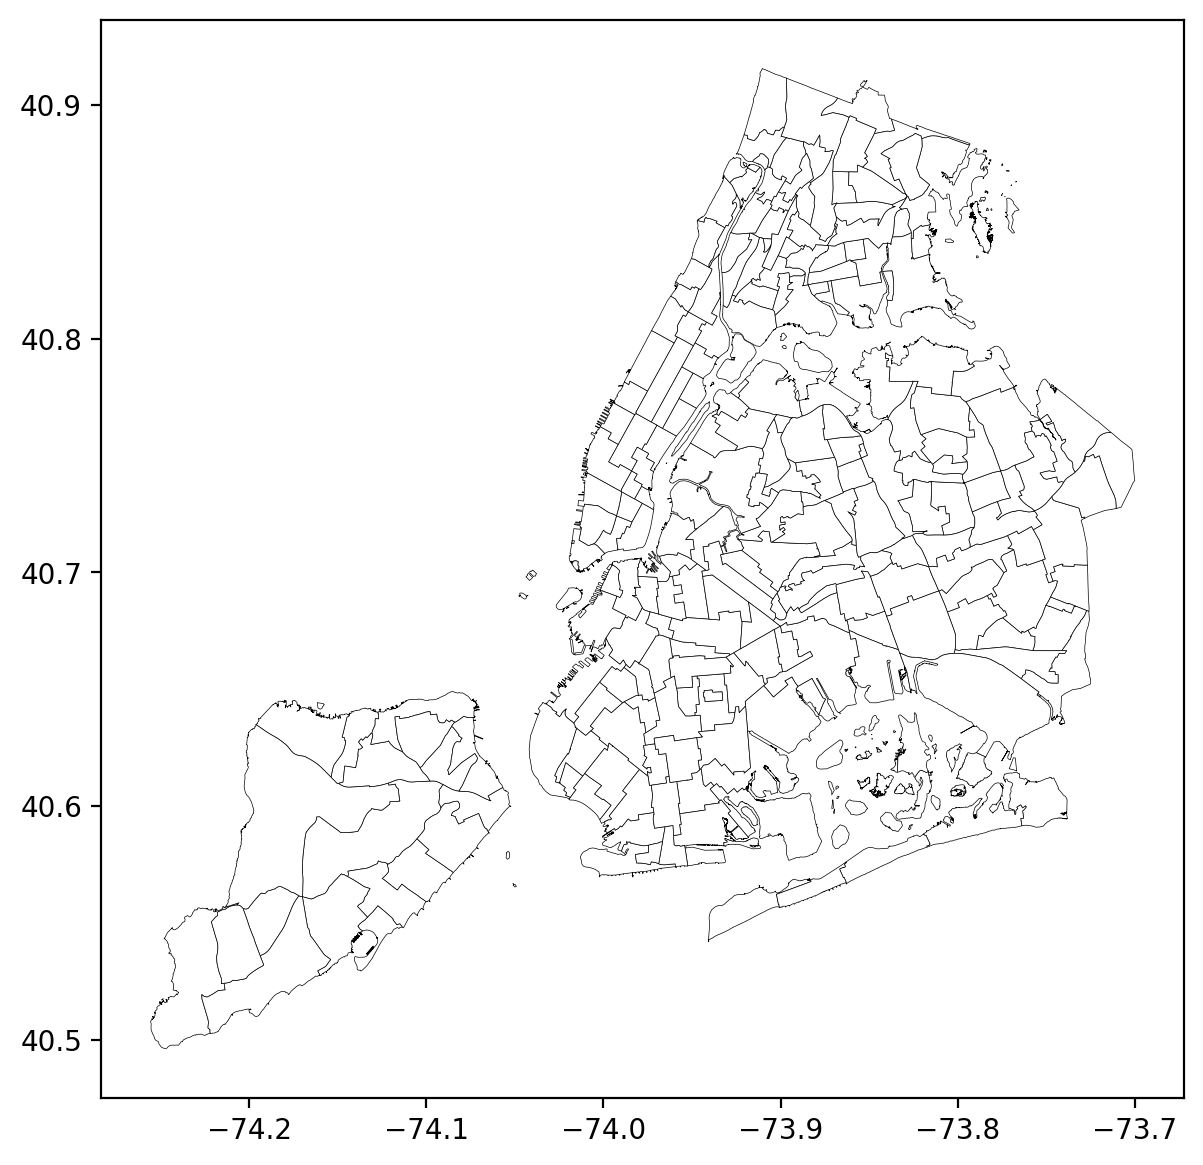

In [ ]:
# Load the shapefile
df_nyc = gpd.GeoDataFrame.from_file('nyc-neighborhoods.geojson')

# Create a plot
df_nyc.plot(linewidth=0.25, color='White', edgecolor='Black', figsize=(7, 7))

In [ ]:
sql = '''
select *
from nypd N
inner join offense_codes OC on N.KY_CD = OC.KY_CD
where OC.OFNS_DESC in('GRAND LARCENY','ROBBERY','FELONY ASSAULT','BURGLARY','GRAND LARCENY OF MOTOR VEHICLE') and (CMPLNT_FR between '2023-01-01' and '2023-12-31') and N.Latitude is not null and N.Longitude is not null
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)

df

CMPLNT_NUM           CMPLNT_FR           CMPLNT_TO      RPT_DT KY_CD  \
0        261196016 2023-01-01 00:00:00 2023-01-01 00:08:00  2023-01-01   106   
1        261236428 2023-01-01 00:00:00 2023-01-01 00:05:00  2023-01-01   109   
2        261245316 2023-01-01 00:00:00 2023-01-01 00:15:00  2023-01-01   109   
3        262175341 2023-01-01 00:00:00 2023-01-17 00:00:00  2023-01-19   109   
4        263021646 2023-01-01 00:00:00 2023-03-09 12:00:00  2023-02-04   109   
...            ...                 ...                 ...         ...   ...   
118075   279748255 2023-12-30 23:30:00 2023-12-31 00:00:00  2023-12-31   110   
118076   279760303 2023-12-30 23:30:00 2023-12-30 23:40:00  2023-12-31   109   
118077   279734637 2023-12-30 23:40:00 2023-12-30 23:50:00  2023-12-31   106   
118078   279734612 2023-12-30 23:45:00 2023-12-30 23:51:00  2023-12-31   109   
118079   279750864 2023-12-30 23:45:00 2023-12-30 23:46:00  2023-12-31   109   

        PD_CD CRM_ATPT_CPTD_CD LAW_CAT_CD  JURISDICTION_CODE        BORO_NM  \
0         109        COMPLETED     FELONY                  0          BRONX   
1         406        COMPLETED     FELONY                  0      MANHATTAN   
2         406        COMPLETED     FELONY                  0      MANHATTAN   
3         439        COMPLETED     FELONY                  0          BRONX   
4         430        COMPLETED     FELONY                  0  STATEN ISLAND   
...       ...              ...        ...                ...            ...   
118075    441        COMPLETED     FELONY                  0         QUEENS   
118076    417        COMPLETED     FELONY                  0      MANHATTAN   
118077    109        COMPLETED     FELONY                  0         QUEENS   
118078    419        COMPLETED     FELONY                  2       BROOKLYN   
118079    415        COMPLETED     FELONY                  0      MANHATTAN   

        ...       SUSP_RACE                  VIC_RACE  SUSP_AGE_GROUP  \
0       ...           WHITE            WHITE HISPANIC           25-44   
1       ...         UNKNOWN                     WHITE            None   
2       ...         UNKNOWN  ASIAN / PACIFIC ISLANDER            None   
3       ...         UNKNOWN                     WHITE            None   
4       ...         UNKNOWN            WHITE HISPANIC            None   
...     ...             ...                       ...             ...   
118075  ...         UNKNOWN  ASIAN / PACIFIC ISLANDER            None   
118076  ...         UNKNOWN            BLACK HISPANIC            None   
118077  ...  WHITE HISPANIC            WHITE HISPANIC            None   
118078  ...           BLACK                     WHITE            None   
118079  ...         UNKNOWN                   UNKNOWN            None   

       VIC_AGE_GROUP SUSP_SEX VIC_SEX   Latitude  Longitude KY_CD  \
0              45-64        M       M  40.822273 -73.924957   106   
1              18-24     None       F  40.758533 -73.988846   109   
2              25-44     None       F  40.758705 -73.993286   109   
3                65+     None       M  40.884823 -73.911263   109   
4              45-64     None       M  40.616093 -74.071915   109   
...              ...      ...     ...        ...        ...   ...   
118075         18-24     None       M  40.767090 -73.834763   110   
118076         18-24     None       F  40.755970 -73.988861   109   
118077         25-44        M       M  40.757282 -73.868996   106   
118078         25-44        M       M  40.666485 -73.921616   109   
118079          None     None       F  40.758224 -73.977425   109   

                             OFNS_DESC  
0                       FELONY ASSAULT  
1                        GRAND LARCENY  
2                        GRAND LARCENY  
3                        GRAND LARCENY  
4                        GRAND LARCENY  
...                                ...  
118075  GRAND LARCENY OF MOTOR VEHICLE  
118076                   GRAND LARCENY  
118077                 

In [ ]:
# Create individual dataframes for each offense type
df_grandlarceny = df[df['OFNS_DESC']=='GRAND LARCENY']
df_robbery = df[df['OFNS_DESC']=='ROBBERY']
df_assault = df[df['OFNS_DESC']=="FELONY ASSAULT"]
df_burglary = df[df['OFNS_DESC']=='BURGLARY']
df_glmotor = df[df['OFNS_DESC']=='GRAND LARCENY OF MOTOR VEHICLE']

<Axes: xlabel='Longitude', ylabel='Latitude'>

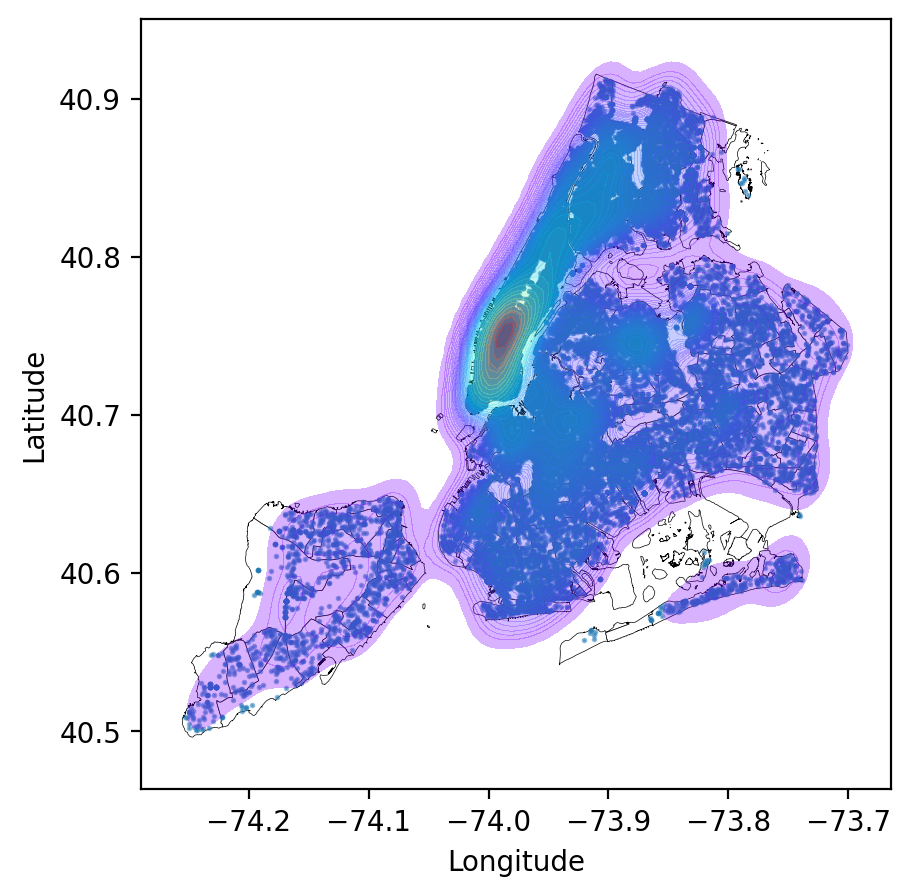

In [ ]:
# Plot for grand larceny
base = df_nyc.plot(linewidth=0.25, color='White', edgecolor='Black', figsize=(5, 5))

scatter = df_grandlarceny.plot(
    kind = 'scatter',
    x = 'Longitude',
    y = 'Latitude',
    s = 1,
    alpha = 0.5,
    ax = base
)

sns.kdeplot(
    data=df_grandlarceny,
    x='Longitude',
    y='Latitude',
    gridsize=100,
    cmap='rainbow',
    fill= True,
    alpha=0.3,
    thresh=0.01,
    n_levels=50,
    ax = scatter
)

<Axes: xlabel='Longitude', ylabel='Latitude'>

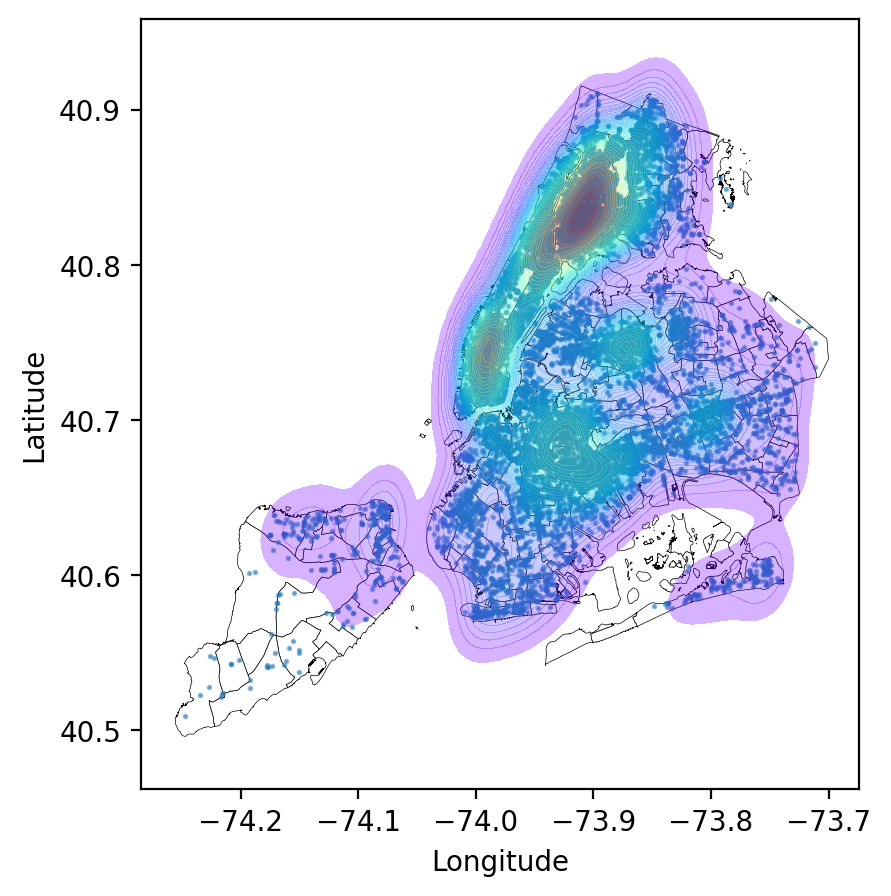

In [ ]:
# Plot for robbery
base = df_nyc.plot(linewidth=0.25, color='White', edgecolor='Black', figsize=(5, 5))

scatter = df_robbery.plot(
    kind = 'scatter',
    x = 'Longitude',
    y = 'Latitude',
    s = 1,
    alpha = 0.5,
    ax = base
)

sns.kdeplot(
    data=df_robbery,
    x='Longitude',
    y='Latitude',
    gridsize=100,
    cmap='rainbow',
    fill= True,
    alpha=0.3,
    thresh=0.01,
    n_levels=50,
    ax = scatter
)

<Axes: xlabel='Longitude', ylabel='Latitude'>

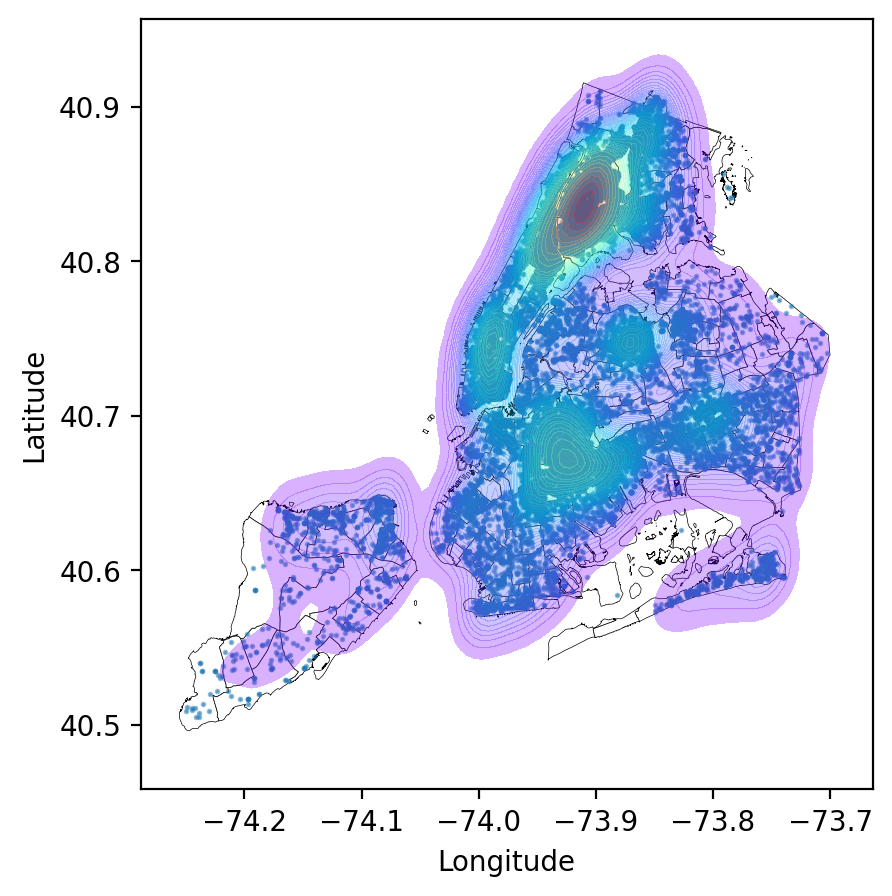

In [ ]:
# Plot for felony assault
base = df_nyc.plot(linewidth=0.25, color='White', edgecolor='Black', figsize=(5, 5))

scatter = df_assault.plot(
    kind = 'scatter',
    x = 'Longitude',
    y = 'Latitude',
    s = 1,
    alpha = 0.5,
    ax = base
)

sns.kdeplot(
    data=df_assault,
    x='Longitude',
    y='Latitude',
    gridsize=100,
    cmap='rainbow',
    fill= True,
    alpha=0.3,
    thresh=0.01,
    n_levels=50,
    ax = scatter
)

<Axes: xlabel='Longitude', ylabel='Latitude'>

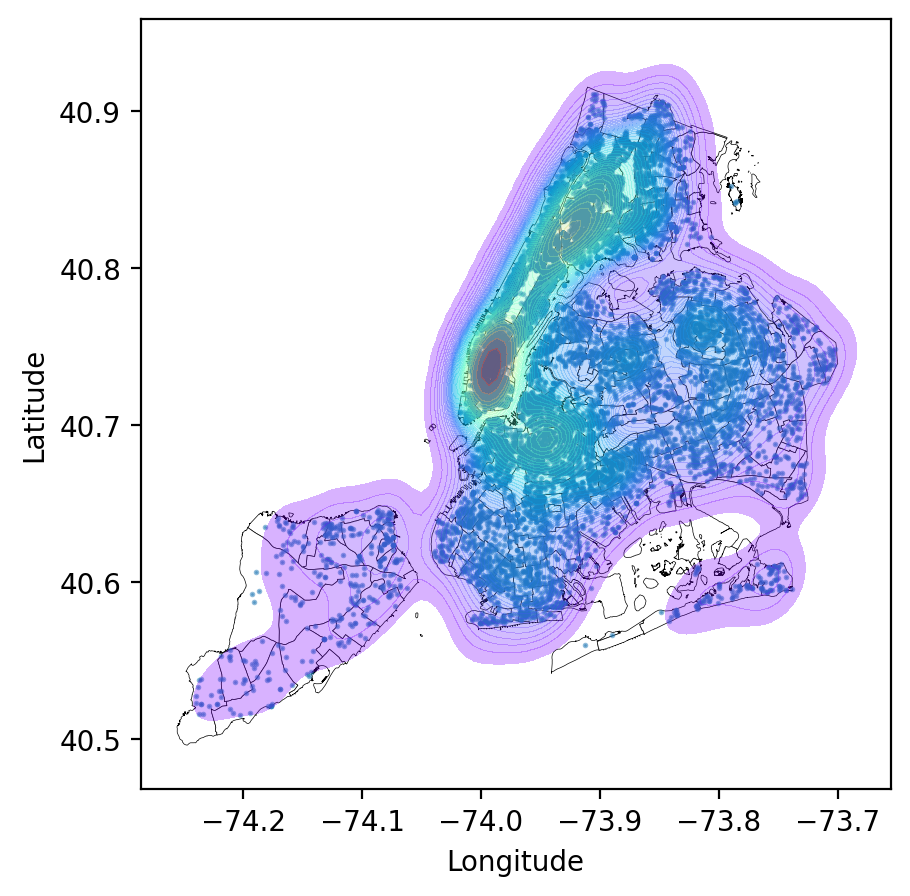

In [ ]:
# Plot for burglary
base = df_nyc.plot(linewidth=0.25, color='White', edgecolor='Black', figsize=(5, 5))

scatter = df_burglary.plot(
    kind = 'scatter',
    x = 'Longitude',
    y = 'Latitude',
    s = 1,
    alpha = 0.5,
    ax = base
)

sns.kdeplot(
    data=df_burglary,
    x='Longitude',
    y='Latitude',
    gridsize=100,
    cmap='rainbow',
    fill= True,
    alpha=0.3,
    thresh=0.01,
    n_levels=50,
    ax = scatter
)

<Axes: xlabel='Longitude', ylabel='Latitude'>

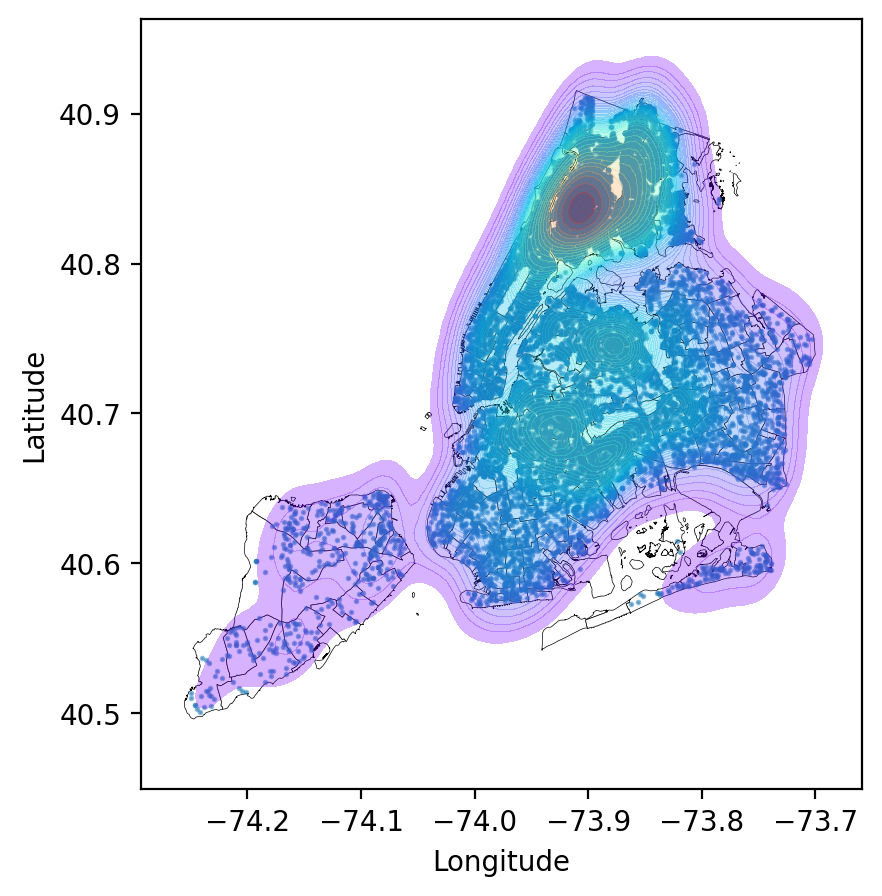

In [ ]:
# Plot for grand larceny of motor vehicle
base = df_nyc.plot(linewidth=0.25, color='White', edgecolor='Black', figsize=(5, 5))

scatter = df_glmotor.plot(
    kind = 'scatter',
    x = 'Longitude',
    y = 'Latitude',
    s = 1,
    alpha = 0.5,
    ax = base
)

sns.kdeplot(
    data=df_glmotor,
    x='Longitude',
    y='Latitude',
    gridsize=100,
    cmap='rainbow',
    fill= True,
    alpha=0.3,
    thresh=0.01,
    n_levels=50,
    ax = scatter
)